In [1]:
# Add project root so we can import spine_score.src modules
# may need to rename spine-score folder to "spine_score"
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

# External libraries
import importlib
from pathlib import Path
import os
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import amp
from tqdm import tqdm
import numpy as np

# Internal modules
from spine_score.src import extract, dataset, model
from spine_score.src.model import SimpleUNet3D, evaluate_model, print_metrics

In [2]:
# Reloads modules (run for development update with the notebook)
importlib.reload(extract) 
importlib.reload(dataset)
importlib.reload(model)

<module 'spine_score.src.model' from 'C:\\Users\\Maxtw\\OneDrive\\Desktop\\Final Project 521\\aai-521-final-project\\spine_score\\src\\model.py'>

In [3]:
import os, glob, re
import pydicom
from collections import defaultdict

# -------------------------------
# 1. Paths
# -------------------------------
dicom_root = "../data/interim/imaging_files/case_image"
mask_root  = "../data/interim/segmentation"

# -------------------------------
# 2. Build DICOM metadata map
# -------------------------------
dicom_meta = defaultdict(list)

print("Scanning DICOM folders...\n")

for patient_folder in glob.glob(os.path.join(dicom_root, "*")):
    patient_id = os.path.basename(patient_folder)

    # All folders containing *.dcm files
    series_dirs = [
        d for d in glob.glob(os.path.join(patient_folder, "**"), recursive=True)
        if os.path.isdir(d) and len(glob.glob(os.path.join(d, "*.dcm"))) > 0
    ]

    for sd in series_dirs:
        example_file = glob.glob(os.path.join(sd, "*.dcm"))[0]

        try:
            ds = pydicom.dcmread(example_file, stop_before_pixels=True)

            dicom_meta[patient_id].append({
                "folder": sd,
                "SeriesInstanceUID": getattr(ds, "SeriesInstanceUID", None),
                "SeriesNumber":     getattr(ds, "SeriesNumber", None),
                "StudyInstanceUID": getattr(ds, "StudyInstanceUID", None),
            })
        except Exception as e:
            print(f"Failed reading {example_file}: {e}")

# -------------------------------
# 3. Build Mask metadata map
# -------------------------------
mask_meta = defaultdict(list)

print("\nScanning mask files...\n")

mask_pattern = re.compile(
    r"(\d+-\d+)_Study-[A-Za-z]+-(\d+)_Series-(\d+)_SEG\.nii\.gz"
)

for mask_file in glob.glob(os.path.join(mask_root, "*.nii.gz")):
    base = os.path.basename(mask_file)

    m = mask_pattern.match(base)
    if m:
        pid, study_num, series_num = m.groups()

        mask_meta[pid].append({
            "file": mask_file,
            "StudyNumber": int(study_num),
            "SeriesNumber": int(series_num)
        })
    else:
        print(f"Could not parse mask name: {mask_file}")

# -------------------------------
# 4. Match masks ↔ DICOM series
# -------------------------------
dataset_entries = []

print("\nMatching masks to DICOM series...\n")

for pid in mask_meta:
    print(f"Patient {pid}:")
    dcm_list = dicom_meta.get(pid, [])

    for mask in mask_meta[pid]:
        target_series = mask["SeriesNumber"]

        match = None
        for dcm in dcm_list:
            if dcm["SeriesNumber"] == target_series:
                match = dcm
                break

        if match:
            dataset_entries.append((pid, match["folder"], mask["file"]))
            print(f"  MATCH: Series {target_series} →")
            print(f"      Image: {match['folder']}")
            print(f"      Mask:  {mask['file']}")
        else:
            print(f"  NO MATCH FOR mask: {mask['file']} (Series {target_series})")

# -------------------------------
# 5. Summary
# -------------------------------
print("\n====================")
print("SUMMARY")
print("====================")
print(f"Total matched pairs: {len(dataset_entries)}\n")

if len(dataset_entries) > 0:
    print("Example pair:")
    print(dataset_entries[0])


Scanning DICOM folders...


Scanning mask files...


Matching masks to DICOM series...

Patient 593973-000001:
  MATCH: Series 22 →
      Image: ../data/interim/imaging_files/case_image\593973-000001\1.2.826.0.1.3680043.10.474.593973.2\1.2.826.0.1.3680043.10.474.593973.3
      Mask:  ../data/interim/segmentation\593973-000001_Study-MR-1_Series-22_SEG.nii.gz
Patient 593973-000002:
  MATCH: Series 3 →
      Image: ../data/interim/imaging_files/case_image\593973-000002\1.2.826.0.1.3680043.10.474.593973.19\1.2.826.0.1.3680043.10.474.593973.20
      Mask:  ../data/interim/segmentation\593973-000002_Study-MR-2_Series-3_SEG.nii.gz
Patient 593973-000003:
  MATCH: Series 3 →
      Image: ../data/interim/imaging_files/case_image\593973-000003\1.2.826.0.1.3680043.10.474.593973.36\1.2.826.0.1.3680043.10.474.593973.37
      Mask:  ../data/interim/segmentation\593973-000003_Study-MR-3_Series-3_SEG.nii.gz
Patient 593973-000004:
  MATCH: Series 3 →
      Image: ../data/interim/imaging_files/case_image

In [4]:
# First split: train + temp (val+test)
train_entries, temp_entries = train_test_split(
    dataset_entries, test_size=0.3, random_state=42
)

# Second split: val + test
val_entries, test_entries = train_test_split(
    temp_entries, test_size=0.5, random_state=42
)

print(f"Dataset samples: {len(dataset_entries)}")
print(f"Train samples: {len(train_entries)}")
print(f"Val samples:   {len(val_entries)}")
print(f"Test samples:  {len(test_entries)}")

Dataset samples: 1255
Train samples: 878
Val samples:   188
Test samples:  189


In [5]:
target_shape = (1, 224, 224, 48) 
target_spacing = (1.0, 1.0, 1.0)

# Creating dataset objects
train_dataset = dataset.SpineSegDataset(train_entries, target_shape=target_shape, target_spacing=target_spacing)
val_dataset   = dataset.SpineSegDataset(val_entries, target_shape=target_shape, target_spacing=target_spacing)
test_dataset  = dataset.SpineSegDataset(test_entries, target_shape=target_shape, target_spacing=target_spacing)

# DataLoaders
# Reduced batch size to 1 to be safe with V-Net memory usage
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=2, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=2, shuffle=False)

In [6]:
# Keep only the first 5 samples for a quick test run
small_train_dataset = Subset(train_dataset, range(5))
small_train_loader = DataLoader(small_train_dataset, batch_size=2, shuffle=True)

small_val_dataset = Subset(val_dataset, range(5))
small_val_loader = DataLoader(small_val_dataset, batch_size=2, shuffle=False)

small_test_dataset = Subset(test_dataset, range(5))
small_test_loader = DataLoader(small_test_dataset, batch_size=2, shuffle=False)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = SimpleUNet3D(in_channels=1, out_channels=3)

state = torch.load("../weights/UNet_0.1-1.0-1.0/UNet_0.1-1.0-1.0.pth", map_location=device)
model.load_state_dict(state)

model = model.to(device)

model.eval()

# Evaluate using your function
mean_dice, class_dice, metrics = evaluate_model(
    model,
    small_test_loader,
    device,
    num_classes=3
)

# Print results
print(f"Overall mean Dice: {mean_dice:.4f}")
for i, d in enumerate(class_dice):
    print(f"Class {i} Dice: {d:.4f}")

class_names = ["Background", "Vertebrae", "Intervertebral Discs"]
print_metrics(metrics, class_names)

cuda
---- DEBUG in __getitem__ ----
volume shape: torch.Size([1, 224, 224, 48])  dtype: torch.float32  min/max: tensor(0.) tensor(1103.6461)
mask shape: torch.Size([1, 224, 224, 48])  dtype: torch.int64  unique: [0 1 2]
Overall mean Dice: 0.8862
Class 0 Dice: 0.9964
Class 1 Dice: 0.8447
Class 2 Dice: 0.8175

===== Evaluation Metrics per Class =====

               Class  Accuracy  Precision  Recall  F1 Score
          Background    0.9920     0.9990  0.9927    0.9959
           Vertebrae    0.9918     0.7437  0.9292    0.8262
Intervertebral Discs    0.9979     0.7388  0.8826    0.8043




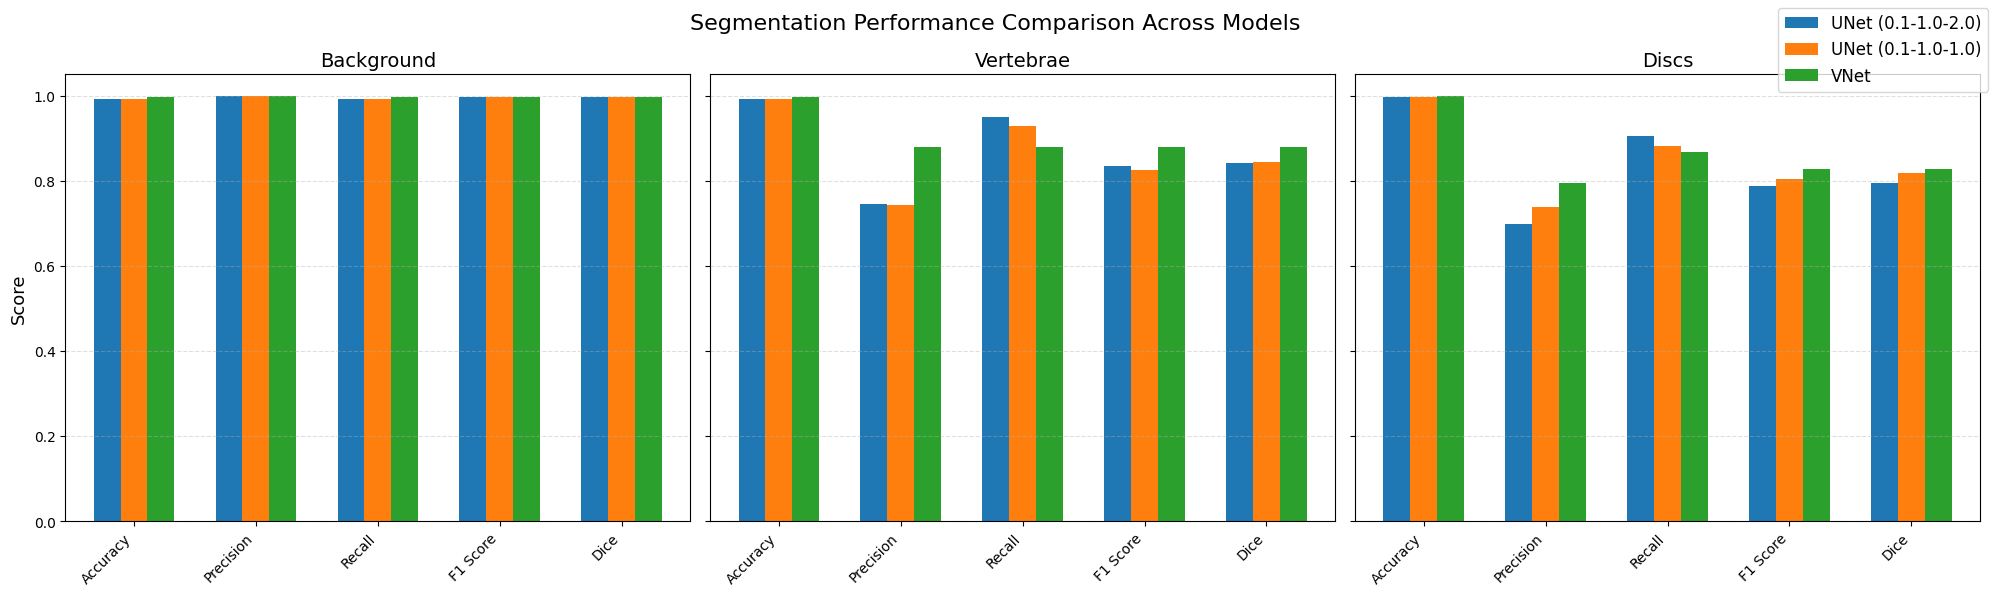

In [1]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "Dice"]

# --- UNet (0.1–1.0–2.0) ---
unet_A = {
    "Background":     [0.9919, 0.9995, 0.9921, 0.9958, 0.9961],
    "Vertebrae":      [0.9922, 0.7448, 0.9502, 0.8351, 0.8415],
    "Discs":          [0.9976, 0.6994, 0.9042, 0.7887, 0.7945],
}

# --- UNet (0.1–1.0–1.0) ---
unet_B = {
    "Background":     [0.9920, 0.9990, 0.9927, 0.9959, 0.9964],
    "Vertebrae":      [0.9918, 0.7437, 0.9292, 0.8262, 0.8447],
    "Discs":          [0.9979, 0.7388, 0.8826, 0.8043, 0.8175],
}

# --- VNet ---
vnet = {
    "Background":     [0.9959, 0.9980, 0.9978, 0.9979, 0.9979],
    "Vertebrae":      [0.9956, 0.8795, 0.8782, 0.8785, 0.8785],
    "Discs":          [0.9984, 0.7941, 0.8665, 0.8286, 0.8286],
}

models = [unet_A, unet_B, vnet]
model_names = ["UNet (0.1-1.0-2.0)", "UNet (0.1-1.0-1.0)", "VNet"]
classes = ["Background", "Vertebrae", "Discs"]

# Plot
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

for ax, cls in zip(axes, classes):
    x = np.arange(len(metrics))
    width = 0.22  # width of each bar

    for i, model in enumerate(models):
        ax.bar(x + i * width, model[cls], width, label=model_names[i])

    ax.set_title(cls, fontsize=14)
    ax.set_xticks(x + width)
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

axes[0].set_ylabel("Score", fontsize=13)
fig.suptitle("Segmentation Performance Comparison Across Models", fontsize=16)
fig.legend(model_names, loc="upper right", fontsize=12)

plt.tight_layout()
plt.show()
